# Laboratorio 14 Aprendizaje de máquinas en gráficos.

Una opción para predecir información sobre el gráfico proviene de aplicar algoritmos clásicos de aprendizaje de máquinas en el contexto de redes.

El laboratorio está centrado en ejemplificar como utilizar el método de Graph Embeddings para proyectar el grafo a un espacio vectorial y en ese espacio intentar realizar la difícil tarea de predecir.

Contenidos:

0.   Graph Embeddings
  1. DeepWalk   
  2. Node2Vec




# Graph Embeddings

Los métodos modernos se encargan de definir features en un espacio vectorial que codifica la información del grafo. De esta manera, la tarea de definir nuevas features queda escondida dentro del algoritmo de aprendizaje de este espacio vectorial. Este tipo de algoritmos son los llamados graphs embeddings, en donde ya no buscamos extraer información directamente del grafo, si no que el objetivo es encontrar un espacio vectorial que contiene toda la información del grafo que nos interesa.

A continuación se importa las nuevas librerías a utilizar: PCA, Word2Vec, Kmeans y Node2Vec.

In [1]:
# !pip install node2vec


In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import random
from tqdm import tqdm # libreria para colocar barra de progreso
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
%matplotlib inline
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from node2vec import Node2Vec



import warnings
warnings.filterwarnings('ignore')

## Deep Walk

Es un algoritmo que nos permite realizar un embedding de un grafo en un espacio vectorial basado en la exploración del grafo mediante una marcha aleatoria entre los nodos.

El proceso de DeepWalk se puede resumir en los siguientes pasos:

1. Generación de caminatas aleatorias.
2. Aprendizaje de incrustaciones.
3. Optimización.

A continuación se mostrará un ejemplo de implementación de dicho método ejemplificado en un grafo aleatorio.

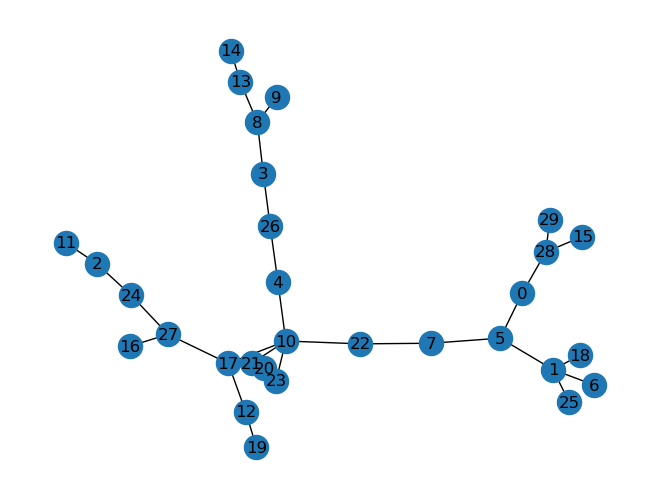

In [3]:
G = nx.generators.trees.random_labeled_tree(30, seed = 123)

nx.draw(G, with_labels = True)

### Generador de caminatas aleatorias

Definamos una función que dado un grafo, un nodo y el largo de la caminata genere un camino aleatorio partiendo desde el nodo dado.

In [4]:
# función para generar secuencias de caminatas aleatorias de nodos para un nodo específico
def get_random_walk(graph, node, walk_length):
    # inicialización
    random_walk_path = [node]

    # bucle para obtener los nodos visitados en una caminata aleatoria
    for i in range(walk_length-1):
        # lista de vecinos
        neighbors = list(graph.neighbors(node))
        # si los mismos vecinos están presentes en la lista random_walk_length, entonces no se agregan como nuevos vecinos
        neighbors = list(set(neighbors) - set(random_walk_path))
        if len(neighbors) == 0:
            break
        # elige aleatoriamente un vecino de la lista de vecinos
        random_neighbor = random.choice(neighbors)
        # agrega ese vecino aleatorio a la lista random_walk_length
        random_walk_path.append(random_neighbor)
        node = random_neighbor

    return random_walk_path




In [5]:
# verificar caminata aleatoria para el nodo '2'
get_random_walk(G, 2, 5)


[2, 11]

De la misma manera podemos extender dicha función a todos los nodos del grafo, obteniendo listas que representan las caminatas aleatorias y será esta información la que representará al grafo.

In [6]:
# calcular caminatas aleatorias para cada nodo en el Grafo

def random_walks_graph(graph, number_of_random_walks, walk_length):

  #number_of_random_walks # Número de caminatas aleatorias por nodo
  #walk_length # Largo de las caminatas
  all_nodes = list(graph.nodes())

  random_walks = []

  for node in tqdm(all_nodes):
      # número de caminatas aleatorias
      for i in range(number_of_random_walks):
          # agregar la secuencia de caminata aleatoria de un nodo de una longitud especificada
          random_walks.append(get_random_walk(graph, node, walk_length))

  return random_walks


In [7]:
random_walks = random_walks_graph(graph = G, number_of_random_walks = 30, walk_length = 8)
# Mostar las 10 primeras caminatas aleatorias
random_walks[:10]

100%|██████████| 30/30 [00:00<00:00, 3220.28it/s]


[[0, 5, 1, 25],
 [0, 28, 15],
 [0, 5, 1, 25],
 [0, 5, 7, 22, 10, 23],
 [0, 5, 7, 22, 10, 4, 26, 3],
 [0, 5, 7, 22, 10, 17, 12, 19],
 [0, 5, 1, 25],
 [0, 28, 29],
 [0, 28, 15],
 [0, 28, 15]]

### Word2Vec

Este modelo es utilizado para aprender representaciones vectoriales densas de palabras en un corpus de texto. La idea central detrás de `Word2Vec` es capturar la semántica y las relaciones entre las palabras en un espacio vectorial de baja dimensión.

La función `Word2Vec` toma como entrada un corpus de texto y aprende representaciones vectoriales para cada palabra en el vocabulario. Estas representaciones son aprendidas a partir del contexto en el que aparecen las palabras en el corpus. El modelo Word2Vec se entrena utilizando técnicas de aprendizaje no supervisado como el modelo de bolsa de palabras (BOW).

In [8]:
# Entrenar word2vec model
model = Word2Vec(window = 10, # windows indica vecinos a tomar en cuenta
                 sg = 1, hs = 0, # sg = 1 ->  algoritmo skip-gram, hs=0 -> utilizar palabras de ruido
                 negative = 10, # for negative sampling = noise words (palabras de ruido)
                 alpha=0.1, min_alpha=0.0007, # alpha tasa o parámetro del optimizador
    )

model.build_vocab(random_walks, progress_per=2)

Luego de generado el "Vocabulario" se optimiza el modelo en busqueda de la representación que maximice la probabilidad de observar la caminata aleatoria en la represenación vectorial del grafo.

In [9]:
model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)
print(model)

Word2Vec<vocab=30, vector_size=100, alpha=0.1>


A continuación, podemos observar los nodos más similares al señalado.

(15, 0.9789098501205444)
(0, 0.96985924243927)
(5, 0.9038609862327576)
(18, 0.8916279673576355)
(25, 0.8779950737953186)
(7, 0.8571515083312988)
(6, 0.8255792260169983)
(28, 0.7943142056465149)
(1, 0.7487770318984985)
(22, 0.7471926212310791)


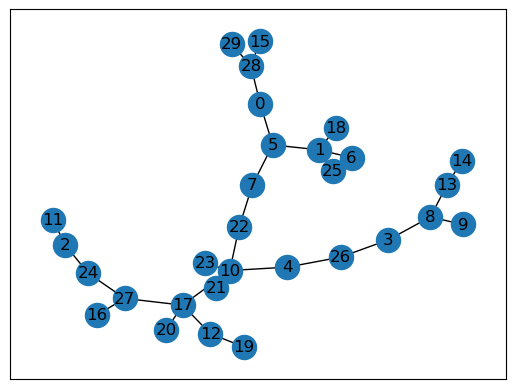

In [10]:
# Nodo más similar al nodo 29
for node, _ in model.wv.most_similar(29):
    print((node, _))

nx.draw_networkx(G)

Dada la representación vectorial obtenida anteriormente podemos realizar una representación gráfica reduciendo la dimensionalidad de los vectores mediante un método de PCA (Análisis de Componentes Principales).

In [11]:
def plot_nodes(word_list, model):
    X = model.wv[word_list]

    # reducimos la dimension a 2
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)


    plt.figure(figsize=(12,9))
    # crear un diagrama de dispersión de la proyección
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))

    plt.show()

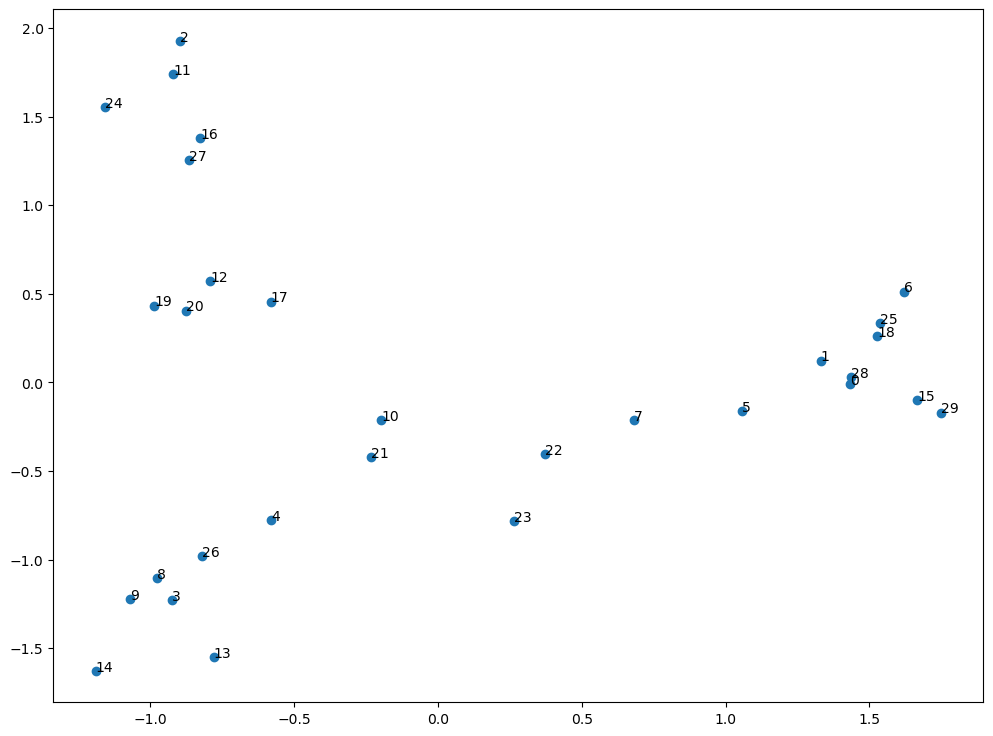

In [12]:
numbers = list(G.nodes)
plot_nodes(numbers, model)

### Clustering

Basado en la representación en 2 dimensiones podemos realizar una clusterización de los puntos(nodos) basado en el popular algoritmo Kmeans, de esta forma podemos obtener una partición del grafo.

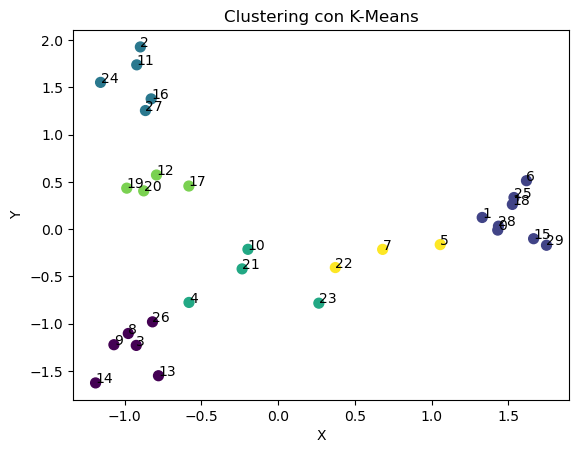

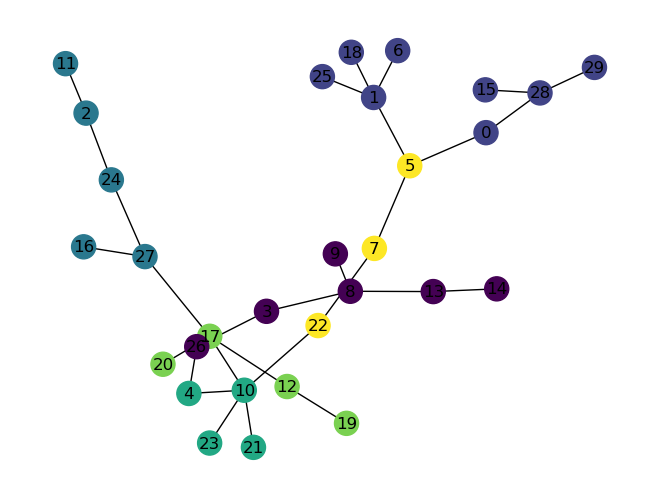

In [13]:
word_list = list(G.nodes)
X = model.wv[word_list]
n_clusters = 6

# reducimos la dimension a 2
pca = PCA(n_components=2)
result = pca.fit_transform(X)

# Aplicar algoritmo de K-Means para clustering
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(result)
y_kmeans = kmeans.predict(result)

# Visualizar los datos y los clústeres
plt.scatter(result[:, 0], result[:, 1], c=y_kmeans, s=50, cmap='viridis')
for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
# Visualizar los centroides de los clústeres
#centers = kmeans.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Clustering con K-Means')
plt.show()
# Dibujar el grafo con colores basados en los atributos
nx.draw(G, with_labels=True, node_color= y_kmeans, cmap='viridis')


### Volvemos al Ejemplo: Zachary's Karate Club

Cada nodo en un gráfico NetworkX tiene un diccionario de *atributos* asociado a él. Este diccionario puede contener datos arbitrarios sobre un nodo. Podemos obtener los atributos de un solo nodo dándole el nombre del nodo al objeto "nodos".

Cada nodo en este gráfico tiene un atributo ``club'', que indica si el miembro siguió al instructor o al presidente después de la división.

Utilizaremos la metodología presentada anteriormente para analizar la partición resultante en este grafo utilizando DeepWalk junto con una representación PCA de dimensión 2 junto al algoritmo de Kmeans.

{'club': 'Mr. Hi'}

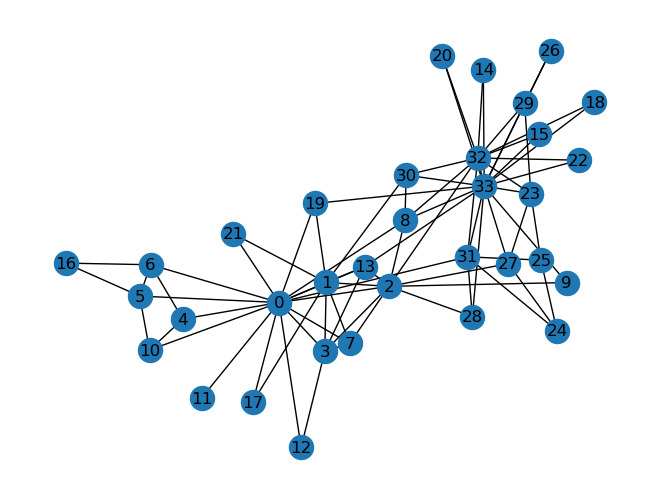

In [14]:
K = nx.karate_club_graph()
nx.draw(K, with_labels=True)
K.nodes[0]


In [15]:
random_walks = random_walks_graph(graph = K, number_of_random_walks = 30, walk_length = 8)

# Entrenar word2vec model
model = Word2Vec(window = 10, # windows indica vecinos a tomar en cuenta
                 sg = 1, hs = 0, # sg = 1 ->  algoritmo skip-gram, hs=0 -> utilizar palabras de ruido
                 negative = 10, # for negative sampling = noise words (palabras de ruido)
                 alpha=0.1, min_alpha=0.0007, # alpha tasa o parámetro del optimizador
    )

model.build_vocab(random_walks, progress_per=2)
model.train(random_walks, total_examples = model.corpus_count, epochs=40, report_delay=1)

100%|██████████| 34/34 [00:00<00:00, 2478.99it/s]


(61977, 294360)

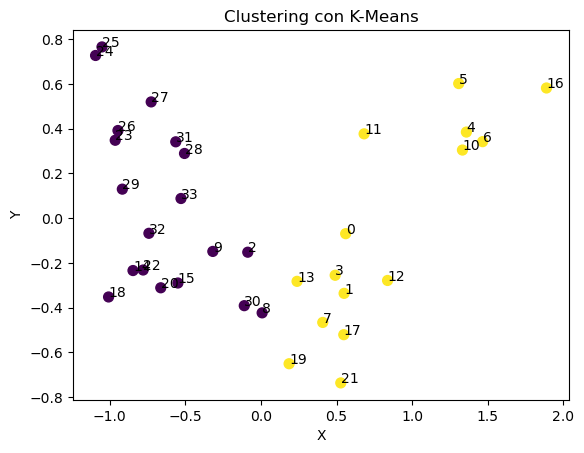

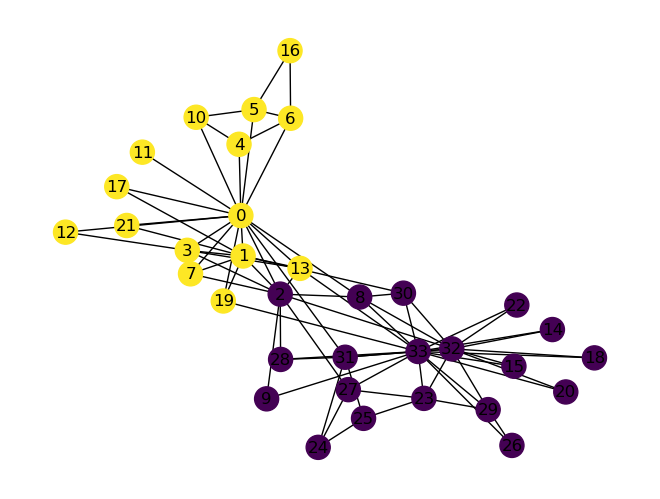

In [16]:
word_list = list(K.nodes)
X = model.wv[word_list]
n_clusters = 2

# reducimos la dimension a 2
pca = PCA(n_components=2)
result = pca.fit_transform(X)

# Aplicar algoritmo de K-Means para clustering
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(result)
y_kmeans = kmeans.predict(result)

# Visualizar los datos y los clústeres
plt.scatter(result[:, 0], result[:, 1], c=y_kmeans, s=50, cmap='viridis')
for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
# Visualizar los centroides de los clústeres
#centers = kmeans.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Clustering con K-Means')
plt.show()
# Dibujar el grafo con colores basados en los atributos
pos = nx.spring_layout(K, seed = 1)
nx.draw(K, with_labels=True, node_color= y_kmeans, cmap='viridis', pos = pos)

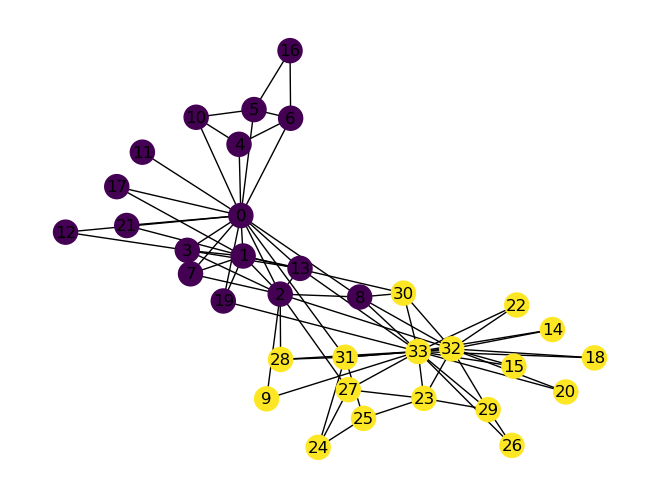

In [17]:
club_color = {
    'Mr. Hi': 0,
    'Officer': 1,
}
node_colors = [club_color[K.nodes[n]['club']] for n in K.nodes]
nx.draw(K, node_color=node_colors,cmap='viridis' ,with_labels=True, pos = pos)

## Node2Vec

Al igual que DeepWalk, Node2Vec se basa en capturar la estructura del grafo mediante una representación de las caminatas aleatorias pero adiciona un parámetro llamado "p" que controla la probabilidad de volver a visitar un nodo recientemente explorado,

In [18]:
# Precalcular probabilidades y generar caminatas - **EN WINDOWS SOLO FUNCIONA CON workers=1**
node2vec = Node2Vec(K, dimensions=100, walk_length=10, num_walks=20, workers=1, p = 1, q = 1)
modeln2v = node2vec.fit(window=10,  epochs=100, min_count=1, sg = 1, hs = 0, negative = 10)


Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 20/20 [00:00<00:00, 829.81it/s]


Al igual que en el modelo DeepWalk podemos obtener los vectores más similares.

In [19]:
# Nodo más similar al nodo 1
for node, _ in modeln2v.wv.most_similar(1):
    print((node, _))


('10', 0.7537022829055786)
('4', 0.7486069798469543)
('7', 0.7081369161605835)
('5', 0.6718549132347107)
('21', 0.6718218922615051)
('16', 0.6642625331878662)
('17', 0.6604911684989929)
('11', 0.6471267938613892)
('1', 0.6415472030639648)
('6', 0.6298302412033081)


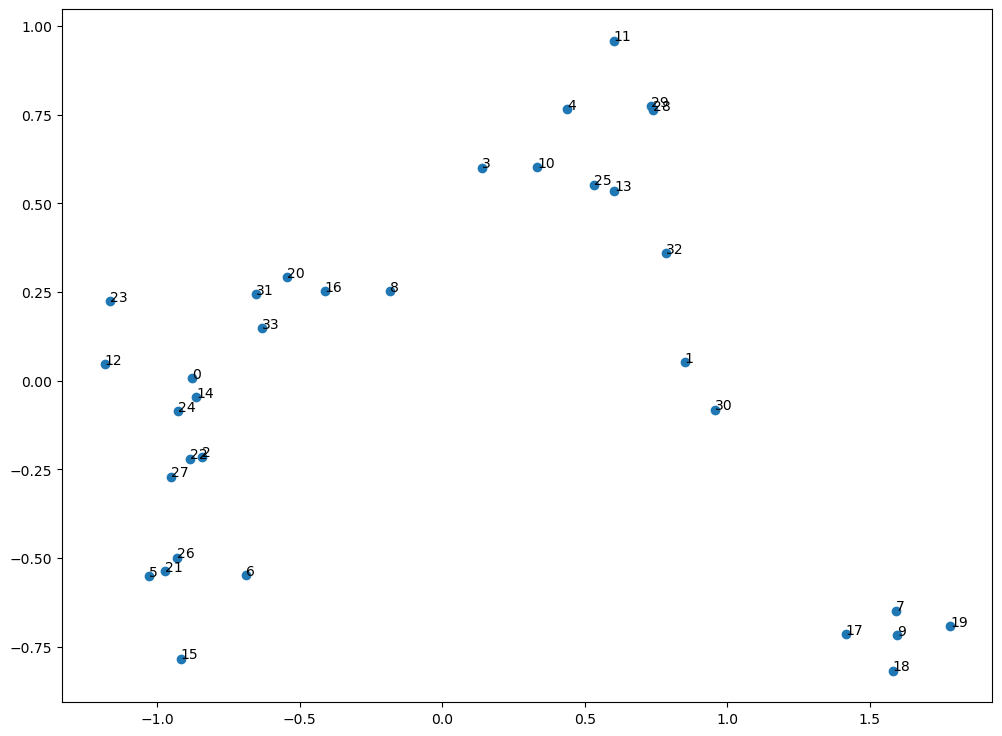

In [20]:
numbers = list(K.nodes)
plot_nodes(numbers, modeln2v)

De manera similar a lo realizado en DeepWalk podemos utilizar la representación vectorial para clusterizar los nodos en 2 particiones.

Si bien los resultados son distintos al esperado esto nos podría hablar acerca de otra relación estructural de los nodos.

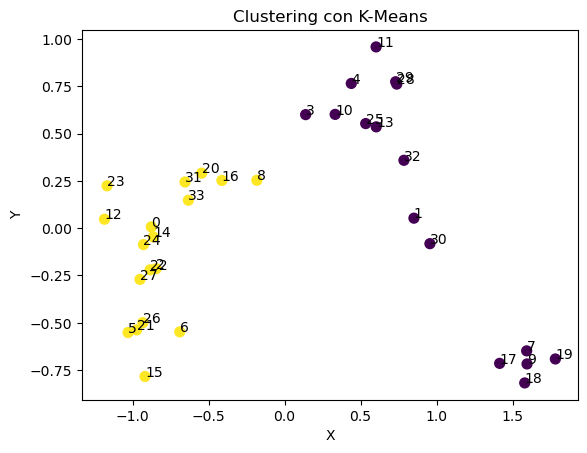

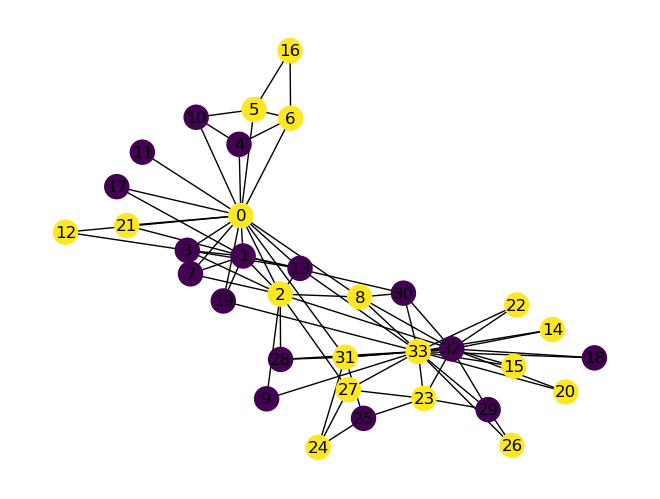

In [21]:
word_list = list(K.nodes)
X = modeln2v.wv[word_list]
n_clusters = 2

# reducimos la dimension a 2
pca = PCA(n_components=2)
result = pca.fit_transform(X)

# Aplicar algoritmo de K-Means para clustering
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(result)
y_kmeans = kmeans.predict(result)

# Visualizar los datos y los clústeres
plt.scatter(result[:, 0], result[:, 1], c=y_kmeans, s=50, cmap='viridis')
for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
# Visualizar los centroides de los clústeres
#centers = kmeans.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Clustering con K-Means')
plt.show()
# Dibujar el grafo con colores basados en los atributos
pos = nx.spring_layout(K, seed = 1)
nx.draw(K, with_labels=True, node_color= y_kmeans, cmap='viridis', pos = pos)